# Importing all the necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import confusion_matrix
from sklearn import base
from scipy.stats import norm
import random as rnd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import time
from tqdm import tqdm
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Dataset Info:

### This data was collected via a survey on Amazon Mechanical Turk. The survey describes different driving scenarios including the destination, current time, weather, passenger, etc., and then ask the person whether he will accept the coupon if he is the driver. For more information about the dataset, please refer to the paper:
### Wang, Tong, Cynthia Rudin, Finale Doshi-Velez, Yimin Liu, Erica Klampfl, and Perry MacNeille. 'A bayesian framework for learning rule sets for interpretable classification.' The Journal of Machine Learning Research 18, no. 1 (2017): 2357-2393.

In [ ]:
df_invehicle = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_invehicle.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## Column names and other info in the Dataset

In [ ]:
df_invehicle.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')

In [ ]:
df_invehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [ ]:
df = df_invehicle

### Most columns in the dataset are categorical

In [ ]:
for col in df:
  print(df[col].unique())

['No Urgent Place' 'Home' 'Work']
['Alone' 'Friend(s)' 'Kid(s)' 'Partner']
['Sunny' 'Rainy' 'Snowy']
[55 80 30]
['2PM' '10AM' '6PM' '7AM' '10PM']
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']
['1d' '2h']
['Female' 'Male']
['21' '46' '26' '31' '41' '50plus' '36' 'below21']
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']
[1 0]
['Some college - no degree' 'Bachelors degree' 'Associates degree'
 'High School Graduate' 'Graduate degree (Masters or Doctorate)'
 'Some High School']
['Unemployed' 'Architecture & Engineering' 'Student'
 'Education&Training&Library' 'Healthcare Support'
 'Healthcare Practitioners & Technical' 'Sales & Related' 'Management'
 'Arts Design Entertainment Sports & Media' 'Computer & Mathematical'
 'Life Physical Social Science' 'Personal Care & Service'
 'Community & Social Services' 'Office & Administrative Support'
 'Construction & Extraction' 'Legal' 'Retired'
 'Installation Maintenance & Repair' 'Trans

### Extracting Time and AM/PM information in the CSV file

In [ ]:
df['AM/PM'] = df.time.str.extract('([a-zA-Z]+)', expand=True)
df['Time'] = df.time.str.extract('([^a-zA-Z]+)', expand=True)
df['Time'] = pd.to_numeric(df['Time'])

### Converting to a 24 hour Time Format

In [ ]:
for j in range(len(df['AM/PM'])):
  if df['AM/PM'].iloc[j] == "PM":
    df['time'].iloc[j] = df['Time'].iloc[j]+12 
  else:
    df['time'].iloc[j] = df['Time'].iloc[j]

### Dropping car, AM/PM and Time columns from the CSV file

In [ ]:
df=df.drop(columns=['car','AM/PM','Time',])
df=df.dropna()

### Extracting all columns where the data type is int64

In [ ]:
df.iloc[:,(df.dtypes=="int64").values].nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

### Since 'toCoupon_GEQ5min' has the value '1' throughout, it does not add any value to our dataset and hence we proceed with dropping that column.

In [ ]:
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

### Univariate Analysis:

### From the plot, we can get to know that, in the destination column of the CSV file, the value 'No Urgent Place' repated the most (almost 6000 entries)

### Similary all the graphs in the below cell tell the count for all the unique values in each column of the CSV file

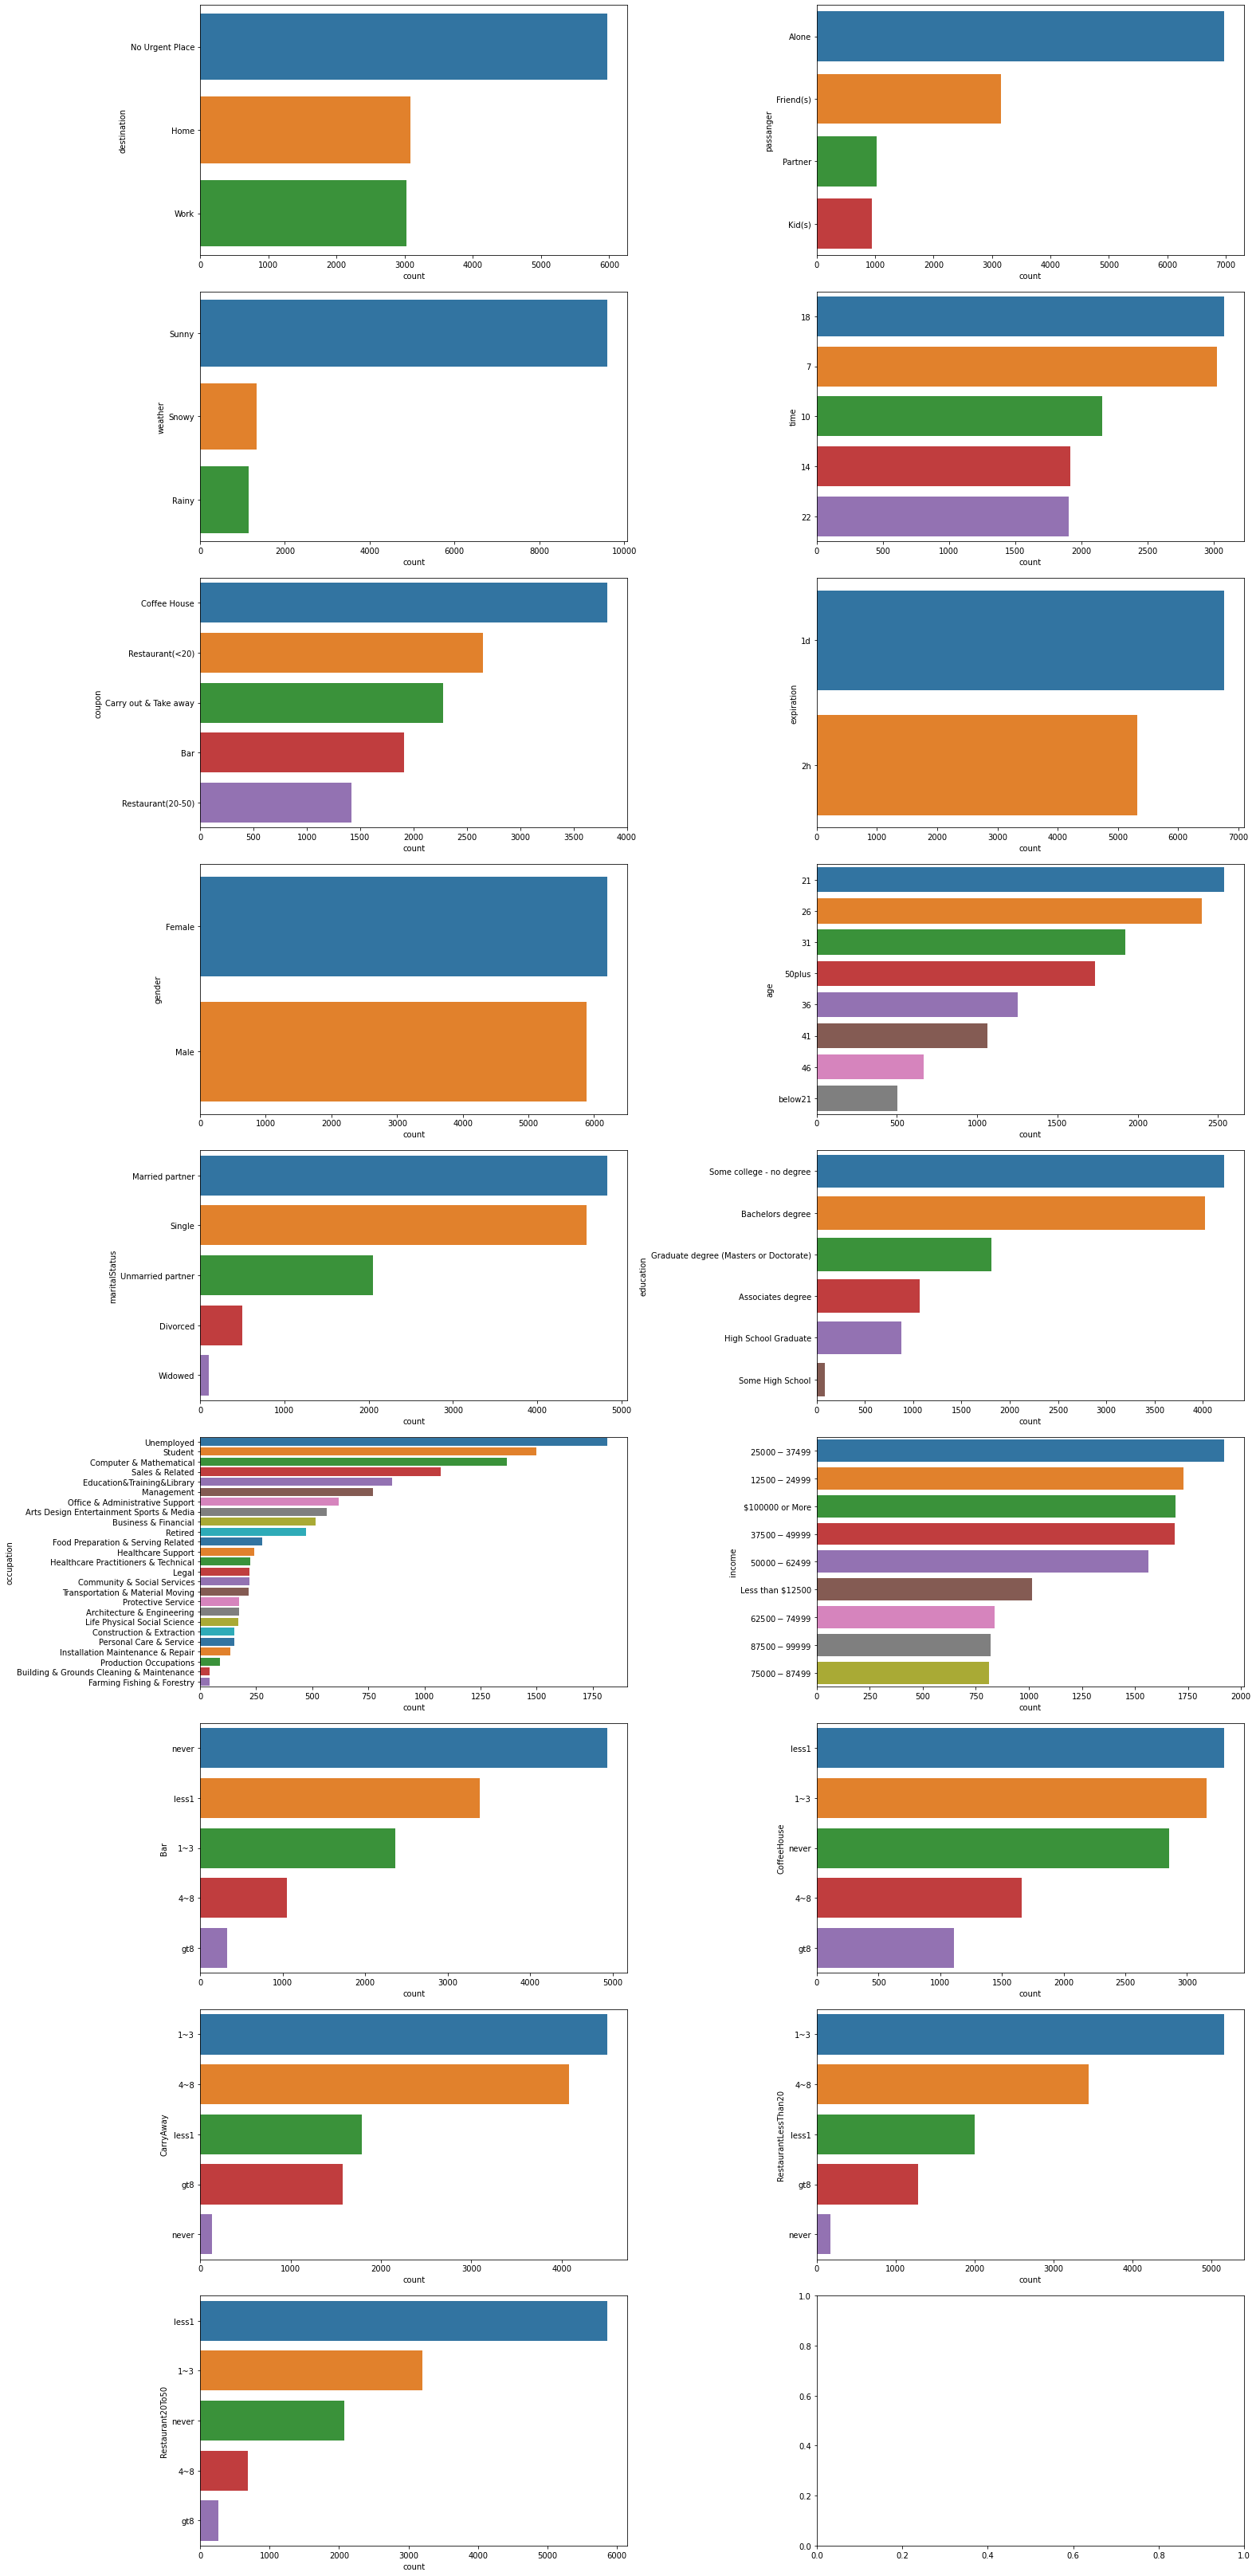

In [ ]:
fig, axes = plt.subplots(9, 2, figsize=(22,45))
axes = axes.flatten()

for ax, col in zip(axes, df.select_dtypes('object').columns):
    sns.countplot(y=col, data=df, ax=ax, 
                  palette="tab10", order=df[col].value_counts().index);

plt.tight_layout()
plt.show()

In [ ]:
frequency_label = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_label = {
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_label = {
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}

In [ ]:
frequency_columns = ['Restaurant20To50', 'RestaurantLessThan20', 
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [ ]:
for col in frequency_columns:
    df[col] = df[col].map(frequency_label)
df.age = df.age.map(age_label)
df.income = df.income.map(income_label)

### Bivariate Analysis:

### This code uses the Python libraries matplotlib and seaborn to create a 3x3 grid of subplots with the specified figsize. The subplots are flattened into a 1D array for convenience.

### Then, a loop is executed where each subplot is assigned to a variable ax, and a categorical variable col is selected from the columns - 'destination', 'passenger', 'weather', 'time', 'coupon', 'expiration', 'gender', 'maritalStatus', 'education', for plotting.

### In each iteration of the loop, the seaborn countplot() function is used to create a bar chart of the col variable, colored by the binary variable Y, and the resulting plot is displayed on the corresponding ax subplot.

### Finally, plt.tight_layout() is called to improve the layout of the subplots, and plt.show() displays the complete figure.

### Overall, the below code is creating a 3x3 grid of bar charts that visualize the distribution of the specified categorical variables in a DataFrame df, colored by the binary variable Y.

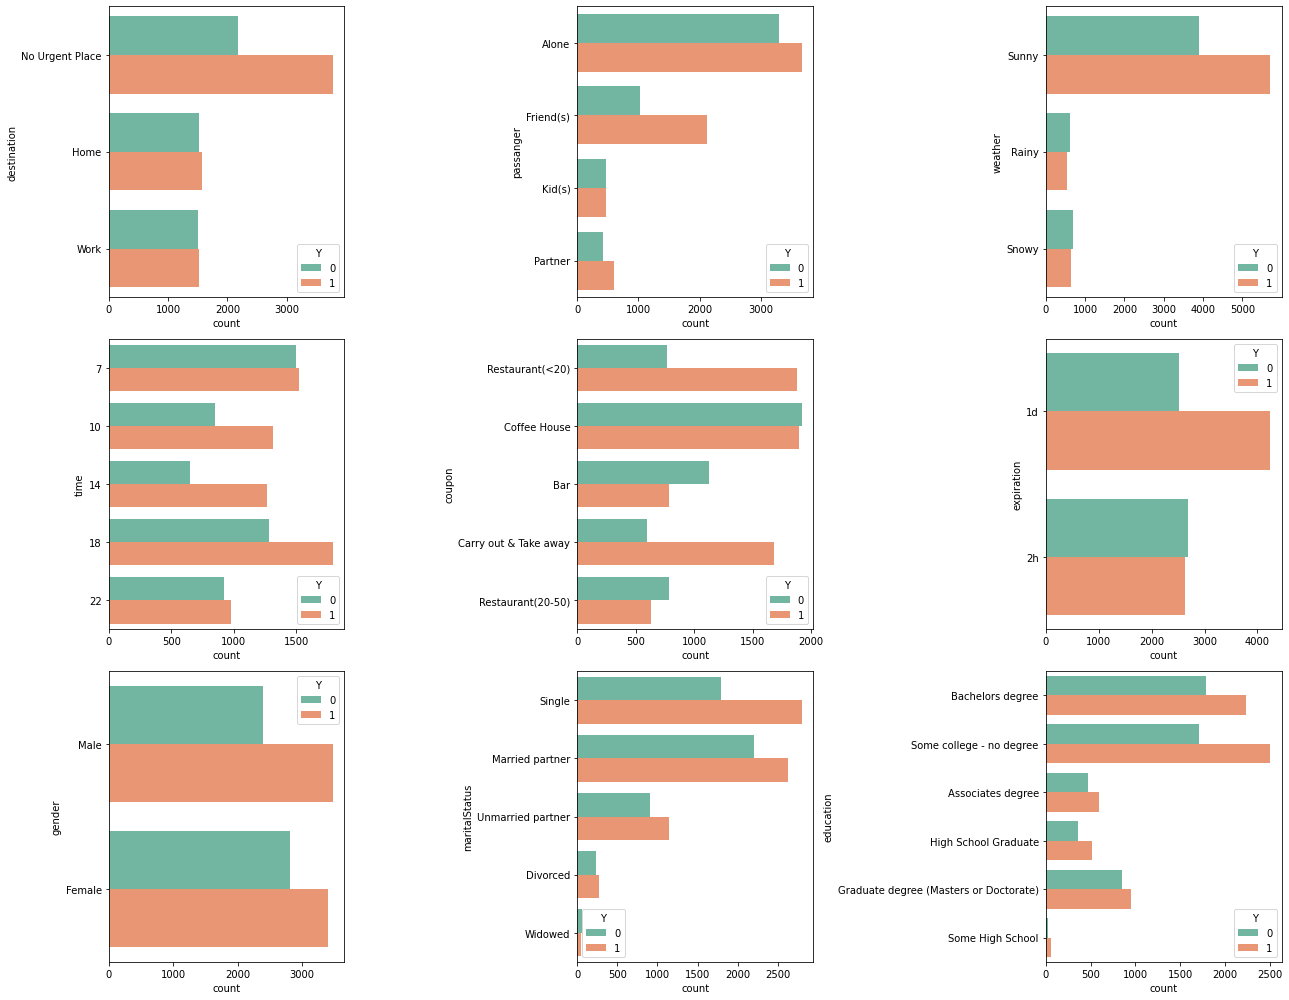

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for ax, col in zip(axes, ['destination', 'passanger', 'weather', 'time', 
                          'coupon', 'expiration', 'gender', 'maritalStatus',
                          'education']):
    sns.countplot(y = col, hue = 'Y', data = df, ax = ax, palette = 'Set2')
plt.tight_layout()
plt.show()

### This below code generates a horizontal bar chart using the seaborn library, displaying the count of different categories of occupations on the y-axis, and the count of two possible values of a binary variable (Y or not Y) on the x-axis.

### The figure size is set to 15 units wide and 20 units tall using plt.subplots(figsize=(15, 20)), and the seaborn countplot() function is used to create the plot. The data parameter specifies the DataFrame containing the data to be plotted, and the hue parameter indicates the column in the DataFrame to be used to create separate bars for the two values of Y. The palette parameter specifies the color palette to use for the bars.

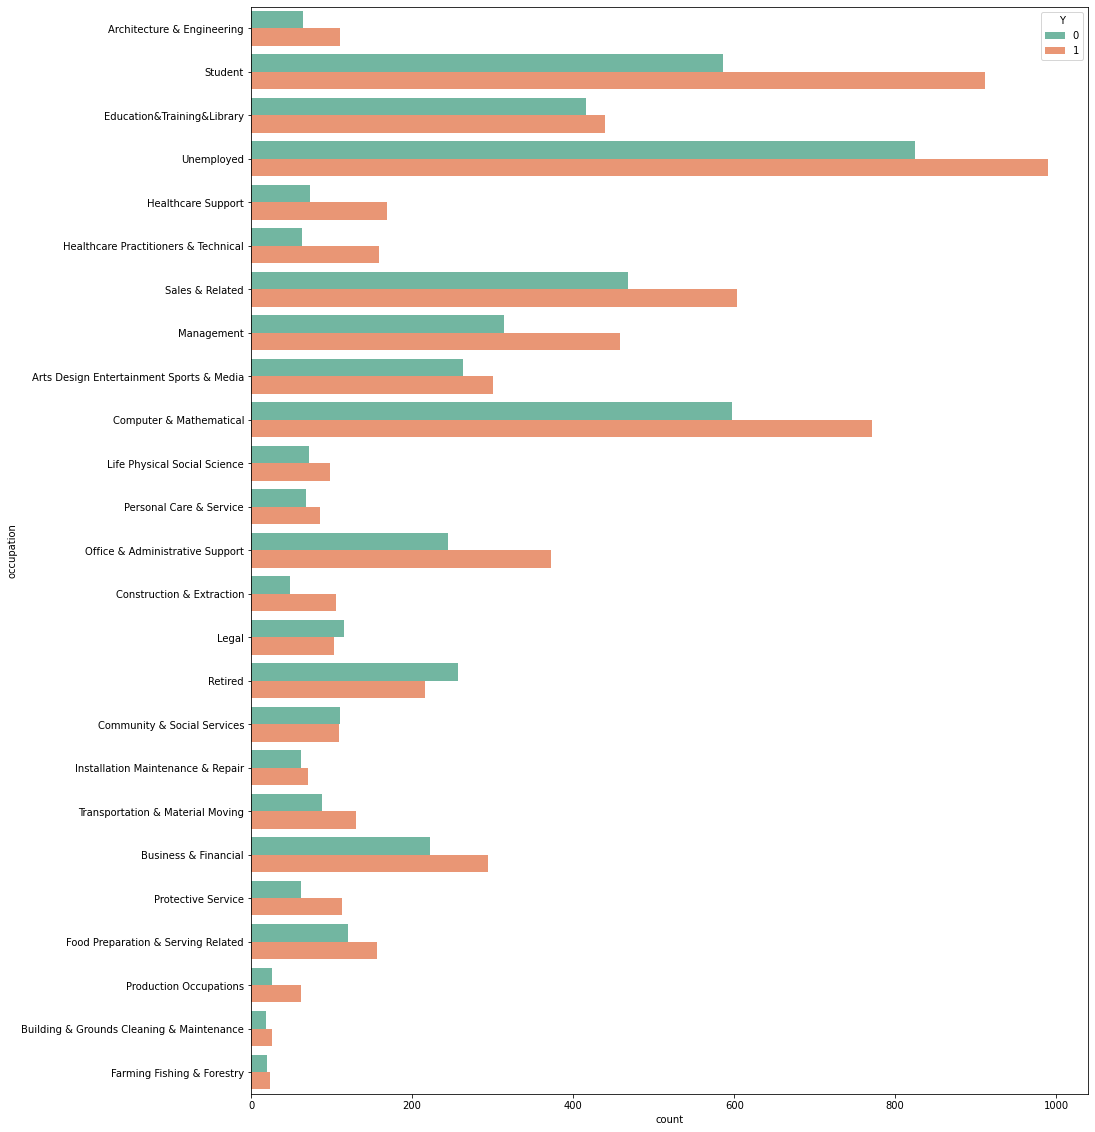

In [ ]:
plt.subplots(figsize=(15, 20))
sns.countplot(y ='occupation', hue='Y', data=df, palette='Set2');
plt.show()

### This below code is to display the correlation plot in a heatmap format

[Text(0.5, 1.0, 'InVehicle Coupon Recommendation Correlation Plot')]

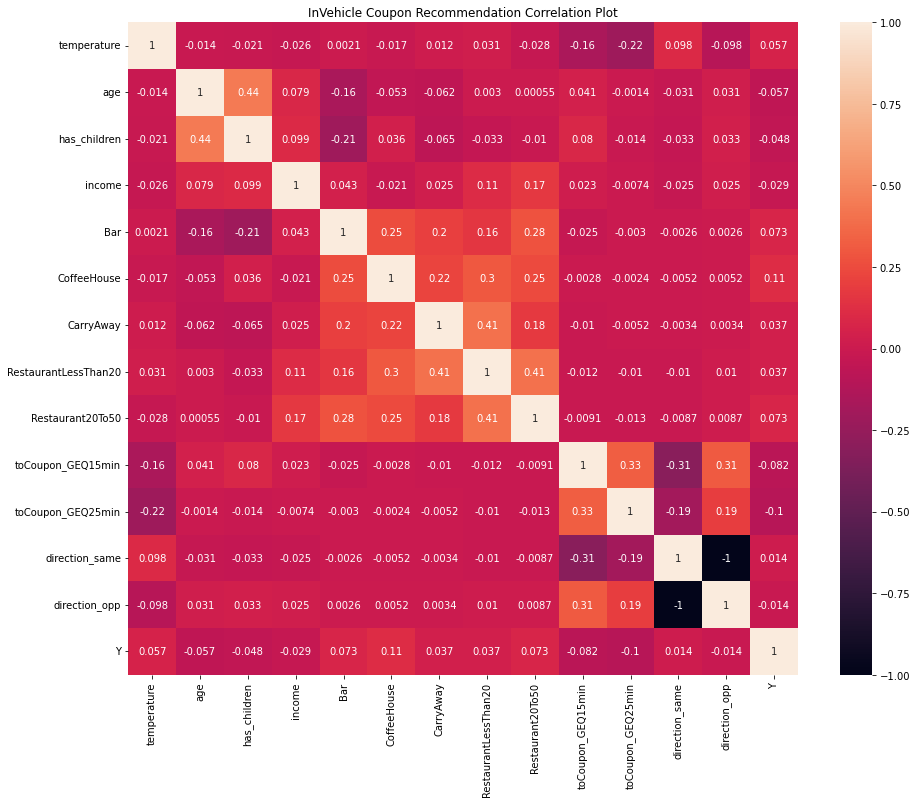

In [ ]:
fig, ax = plt.subplots(figsize=(15, 12))
dfcorr=df.corr()
sns.heatmap(dfcorr, annot=True).set(title="InVehicle Coupon Recommendation Correlation Plot")

### As we can see, direction_same and direction_opp columns have a correlation of '-1'. This means that they are compliments of each other, hence we need to drop one of them.

In [ ]:
#Dropping column 'direction_opp':
df.drop(columns=['direction_opp'], inplace=True)

### To get rid of the 'toCoupon_GEQ15min' and 'toCoupon_GEQ25min' columns, we are encoding them by assigning them values.

In [ ]:
df['drive_distance'] = None
df.loc[df['toCoupon_GEQ15min'] == 0, 'drive_distance'] = 0
df.loc[(df['toCoupon_GEQ15min'] == 1) & \
             (df['toCoupon_GEQ25min'] == 0), 'drive_distance'] = 1
df.loc[df['toCoupon_GEQ25min'] == 1, 'drive_distance'] = 2
df.drive_distance.isna().sum()

0

### After encoding the columns 'toCoupon_GEQ15min' and 'toCoupon_GEQ25min', we can now drop those columns.

In [ ]:
df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)

### Scaling temperature and time:

### In this standard scaler function, which uses the z - score, to normalize the entire data by subtracting the mean and dividing by the standard deviation of each feature, resulting in a standard normal distribution with mean 0 and standard deviation 1.

In [ ]:
scalar = StandardScaler()
col = ['temperature', 'time']
df[col] = scalar.fit_transform(df[col])
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,occupation,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,Y,drive_distance
22,No Urgent Place,Alone,Sunny,-0.435632,0.034656,Restaurant(<20),1d,Male,1,Single,...,Architecture & Engineering,5,0,1,3,3,1,0,1,0
23,No Urgent Place,Friend(s),Sunny,0.871048,-0.704935,Coffee House,2h,Male,1,Single,...,Architecture & Engineering,5,0,1,3,3,1,0,0,0
24,No Urgent Place,Friend(s),Sunny,0.871048,-0.704935,Bar,1d,Male,1,Single,...,Architecture & Engineering,5,0,1,3,3,1,0,1,0
25,No Urgent Place,Friend(s),Sunny,0.871048,-0.704935,Carry out & Take away,2h,Male,1,Single,...,Architecture & Engineering,5,0,1,3,3,1,0,0,1
26,No Urgent Place,Friend(s),Sunny,0.871048,0.034656,Coffee House,1d,Male,1,Single,...,Architecture & Engineering,5,0,1,3,3,1,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 22 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   destination           12079 non-null  object 
 1   passanger             12079 non-null  object 
 2   weather               12079 non-null  object 
 3   temperature           12079 non-null  float64
 4   time                  12079 non-null  float64
 5   coupon                12079 non-null  object 
 6   expiration            12079 non-null  object 
 7   gender                12079 non-null  object 
 8   age                   12079 non-null  int64  
 9   maritalStatus         12079 non-null  object 
 10  has_children          12079 non-null  int64  
 11  education             12079 non-null  object 
 12  occupation            12079 non-null  object 
 13  income                12079 non-null  int64  
 14  Bar                   12079 non-null  int64  
 15  CoffeeHouse       

### This code creates a figure with two subplots arranged horizontally using the subplots() function from the matplotlib.pyplot library. Each subplot is assigned to an individual axis object in a numpy array returned by the function.

### For each subplot, the sns.countplot() function from the Seaborn library is used to create a count plot of the drive_distance and temperature variables from a pandas DataFrame df. The count plots show the frequency of values in each variable, and they are colored by the binary variable Y.

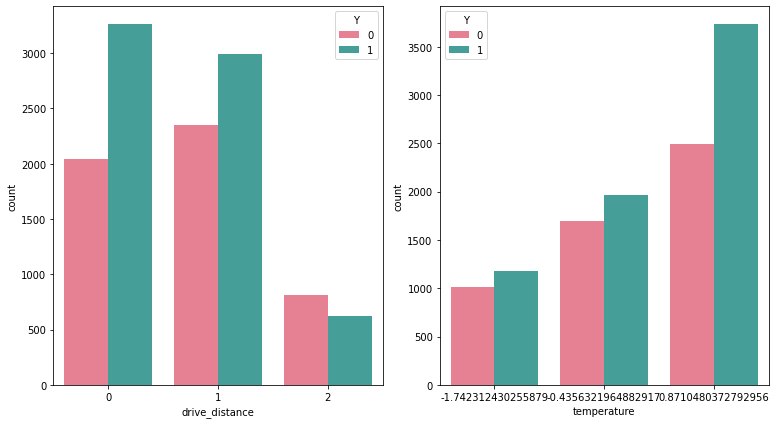

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
axes = axes.flatten()

for ax, col in zip(axes, ['drive_distance', 'temperature']):
    sns.countplot(x=col, hue='Y', data=df,
                  ax=ax, palette="husl");

plt.tight_layout()
plt.show()

### To convert categorical variables to numerical variables, we are label encoding them using the LabelEncoder() class

In [ ]:
df_rf=df
label_encoder_le = LabelEncoder()
df_e_l=pd.DataFrame()
test=pd.DataFrame()
for i in df_rf.columns:
    if df_rf[i].dtypes=="object": #exclude numerical features 
        df_e_l[i]= label_encoder_le.fit_transform(df_rf[i])
    else:
        test[i]=df_rf[i]

In [ ]:
df_e_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   destination     12079 non-null  int32
 1   passanger       12079 non-null  int32
 2   weather         12079 non-null  int32
 3   coupon          12079 non-null  int32
 4   expiration      12079 non-null  int32
 5   gender          12079 non-null  int32
 6   maritalStatus   12079 non-null  int32
 7   education       12079 non-null  int32
 8   occupation      12079 non-null  int32
 9   drive_distance  12079 non-null  int32
dtypes: int32(10)
memory usage: 472.0 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 22 to 12683
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temperature           12079 non-null  float64
 1   time                  12079 non-null  float64
 2   age                   12079 non-null  int64  
 3   has_children          12079 non-null  int64  
 4   income                12079 non-null  int64  
 5   Bar                   12079 non-null  int64  
 6   CoffeeHouse           12079 non-null  int64  
 7   CarryAway             12079 non-null  int64  
 8   RestaurantLessThan20  12079 non-null  int64  
 9   Restaurant20To50      12079 non-null  int64  
 10  direction_same        12079 non-null  int64  
 11  Y                     12079 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 1.5 MB


In [ ]:
test_id=test
test_id.insert(0, 'id', range(1, 1 + len(test_id)))

df_e_l_id=df_e_l
df_e_l_id.insert(0, 'id', range(1, 1 + len(df_e_l)))

In [ ]:
test_id

,id,temperature,time,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,Y
22,1,-0.435632,0.034656,1,0,5,0,1,3,3,1,0,1
23,2,0.871048,-0.704935,1,0,5,0,1,3,3,1,0,0
24,3,0.871048,-0.704935,1,0,5,0,1,3,3,1,0,1
25,4,0.871048,-0.704935,1,0,5,0,1,3,3,1,0,0
26,5,0.871048,0.034656,1,0,5,0,1,3,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,12075,-0.435632,0.774247,2,0,6,0,0,2,3,2,1,1
12680,12076,-0.435632,-1.259628,2,0,6,0,0,2,3,2,0,1
12681,12077,-1.742312,-1.259628,2,0,6,0,0,2,3,2,1,0
12682,12078,-1.742312,-1.259628,2,0,6,0,0,2,3,2,0,0


In [ ]:
df_n = df_e_l_id.merge(test_id, how='left',on='id')
df_n.head()

,id,destination,passanger,weather,coupon,expiration,gender,maritalStatus,education,occupation,...,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same,Y
0,1,1,0,2,4,0,1,2,1,0,...,1,0,5,0,1,3,3,1,0,1
1,2,1,1,2,2,1,1,2,1,0,...,1,0,5,0,1,3,3,1,0,0
2,3,1,1,2,0,0,1,2,1,0,...,1,0,5,0,1,3,3,1,0,1
3,4,1,1,2,1,1,1,2,1,0,...,1,0,5,0,1,3,3,1,0,0
4,5,1,1,2,2,0,1,2,1,0,...,1,0,5,0,1,3,3,1,0,0


In [ ]:
df_n.drop(columns=['id','occupation'], inplace=True)

In [ ]:
df=df_n

### Data Splitting into Traning, Testing and Validation using "train_test_split" function

In [ ]:
X = df.drop(columns = ['Y'])
Y =  df['Y']
X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)# Splitting into test, validation and test sets.

In [ ]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((9663, 20), (9663,), (1208, 20), (1208,), (1208, 20), (1208,))

In [ ]:
X_train

,destination,passanger,weather,coupon,expiration,gender,maritalStatus,education,drive_distance,temperature,time,age,has_children,income,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,direction_same
3958,1,1,2,4,1,0,1,5,1,0.871048,0.034656,7,0,2,0,0,2,3,0,0
6450,2,0,1,4,1,1,2,5,2,-1.742312,-1.259628,1,0,6,2,3,1,1,0,0
10325,1,3,0,0,1,0,1,2,1,-0.435632,0.774247,2,0,7,0,3,1,3,1,0
11462,1,1,2,0,1,0,1,1,1,-0.435632,1.513838,1,1,3,0,1,2,2,1,0
9141,1,1,2,2,0,0,3,1,1,0.871048,1.513838,3,1,5,0,2,3,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7201,1,0,2,2,1,0,2,5,0,-0.435632,0.774247,4,1,1,0,1,4,3,1,0
10204,2,0,1,1,0,0,1,5,1,-1.742312,-1.259628,2,1,2,0,0,2,1,0,1
433,1,1,2,1,1,1,2,3,1,0.871048,-0.704935,3,1,4,4,4,4,4,4,0
5717,2,0,2,3,1,0,0,2,1,0.871048,-1.259628,7,0,3,0,0,3,2,0,0


### Evaluate Function:

In [ ]:
def evaluate(y, y_hat):

      y = (y == 1)
      y_hat = (y_hat == 1)
      accuracy = (y == y_hat).sum() / y.size
      recall = (y & y_hat).sum()/ y.sum()
      precision = (y & y_hat).sum()/ y_hat.sum()

      f_score = 2*(precision * recall)/(precision+recall)  
      print(confusion_matrix(y, y_hat))     
      return accuracy, recall, precision, f_score 

### Creating the Logistic Regression class:

In [ ]:
class LogisticRegression:
    def __init__(self, X_train, X_test, y_train, y_test, learningRate, tolerance, maxIteration) -> None:
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.learningRate = learningRate
        self.tolerance = tolerance
        self.maxIteration = maxIteration
      
    
    def sigmoid(self, z):
        sig = 1 / (1 + np.exp(-z))
        return sig

    def costFunction(self, X, y, i):
        sig = self.sigmoid(X.dot(self.w))

        if i == 1:
            cost = (y * np.log(sig) + (1-y)*np.log(1-sig)).sum()
            cost = -cost/X.shape[0]
        else:

            cost = np.log(np.ones(X.shape[0]) + 
                          np.exp(X.dot(self.w))) - X.dot(self.w)*y
            cost = cost.sum()
        return cost


    def gradient(self, X,y):
        sig = self.sigmoid(X.dot(self.w))
        gradient = (sig - y).dot(X)
        return gradient

    def gradientDescent(self, X, y):
        errors_list = []
        last_error = float('inf')

        for i in tqdm(range(self.maxIteration)):
            #learning rate decay function
            learningRate = self.learningRate/(1+i*2)
            
            self.w = self.w - self.learningRate* self.gradient(X,y)

            current_error = self.costFunction(X,y, 2)
            diff = last_error - current_error
            last_error = current_error
            errors_list.append(current_error)

            if np.abs(diff) < self.tolerance:
                print('Model has stopped learning')
                break
        
        self.error_plot(errors_list)

        
        return

    def predict(self, X):
        sig = self.sigmoid(X.dot(self.w))
        return np.around(sig)

    def fit(self):
        self.w = np.ones(self.X_train.shape[1], dtype = np.float64)*0

        self.gradientDescent(self.X_train, self.y_train)
        print(self.w)

        y_train_hat = self.predict(self.X_train)
        
        f_score, recall, precision, accuracy = evaluate(self.y_train, y_train_hat)
        print('F score of training data {} '.format(f_score))
        print('Recall of training data {}'.format(recall))
        print('Precision of training data {}'.format(precision))
        print('Accuracy of training data {}'.format(accuracy))
        
        self.y_test_hat = self.predict(self.X_test)

        f_score, recall, precision, accuracy = evaluate(self.y_test, self.y_test_hat)
        print('F1 score of test data {} '.format(f_score))
        print('Recall of test data {}'.format(recall))
        print('Precision of test data {}'.format(precision))
        print('Accuracy of test data {}'.format(accuracy))

     

    def error_plot(self, errors_list):


      y_axis = errors_list
      x_axis = list(range(0,len(errors_list)))

            
      fig, ax = plt.subplots()
      ax.plot(x_axis,y_axis)
            
      ax.set (xlabel = 'Iterations', ylabel = 'Error')
      plt.show()

    
    

In [ ]:
reg = LogisticRegression(X_train, X_test, y_train, y_test, learningRate = 0.000001, tolerance = 0.00001, maxIteration = 25000)

### Training the model using the .fit() function

 44%|████████████████████████████████▉                                          | 10987/25000 [01:19<01:40, 139.07it/s]


Model has stopped learning


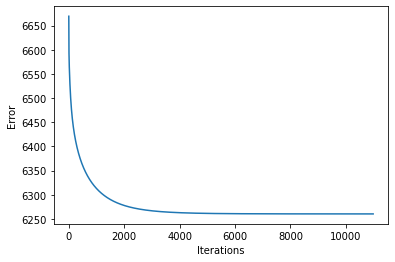

destination             0.076789
passanger               0.156745
weather                 0.182365
coupon                  0.149234
expiration             -0.642911
gender                  0.162954
maritalStatus          -0.075206
education               0.024566
drive_distance         -0.209401
temperature             0.053643
time                    0.015063
age                    -0.039305
has_children           -0.168653
income                 -0.033077
Bar                     0.031020
CoffeeHouse             0.191914
CarryAway              -0.028136
RestaurantLessThan20   -0.100561
Restaurant20To50        0.148439
direction_same          0.079639
dtype: float64
[[1742 2426]
 [1176 4319]]
F score of training data 0.6272379178309013 
Recall of training data 0.7859872611464969
Precision of training data 0.6403261675315048
Accuracy of training data 0.705718954248366
[[217 306]
 [141 544]]
F1 score of test data 0.6299668874172185 
Recall of test data 0.7941605839416058
Precision of tes

In [ ]:
startlr = time.perf_counter()
reg.fit()
endlr = time.perf_counter()
print('Execution Completed in:', endlr - startlr)
lr_timer = endlr - startlr

### Generating the prediction on the validation data, using the .predict() function

In [ ]:
y_validation_predictions = reg.predict(X_valid)

### Calculating the Evaluation Metrics (Accracy, Reacll, Precision, F1 Score) using the evaluate function

In [ ]:
f_score, recall, precision, accuracy = evaluate(y_valid, y_validation_predictions)
print('F1 score of validation data {} '.format(f_score))
print('Recall of validation data {}'.format(recall))
print('Precision of validation data {}'.format(precision))
print('Accuracy of validation data {}'.format(accuracy))

[[219 292]
 [160 537]]
F1 score of validation data 0.6258278145695364 
Recall of validation data 0.7704447632711621
Precision of validation data 0.6477683956574186
Accuracy of validation data 0.7038007863695936


### Plotting the ROC and AUC curves

### By plotting the ROC curve and calculating the AUC, you can evaluate how well your model is able to distinguish between positive and negative examples. The ROC curve provides a visual representation of the performance of your model at different thresholds, allowing you to select a threshold that balances the trade-off between TPR and FPR based on your specific application. 

### The AUC is a summary statistic that provides a single number that can be used to compare the performance of different models or to track the performance of a model over time.

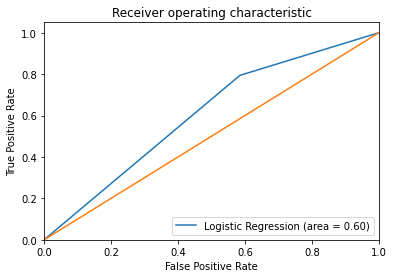

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, reg.predict(X_test)[:])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Defining the KNN class:

In [ ]:
y_train_n = np.array(y_train)
y_test_n = np.array(y_test)

In [ ]:
import numpy as np
from scipy.stats import mode
 
def eucledian(d1,d2):
    dis = np.sqrt(np.sum((d1-d2)**2))
    return dis
 

def predictKNN(X_train, y , X_input, k):
    op_labels = []
     

    for item in X_input: 
         
        p_dist = []
         
        for j in range(len(X_train)): 
            distances = eucledian(np.array(X_train[j,:]) , item) 
            p_dist.append(distances) 
        p_dist = np.array(p_dist) 
         
        dist = np.argsort(p_dist)[:k] 
         
        labels = y[dist]
         
        lab = mode(labels) 
        lab = lab.mode[0]
        op_labels.append(lab)
 
    return op_labels

### Similar to the above working of the Logistic Regression training flow, we are now fitting and predicting the values using the KNN function

In [ ]:
startknn = time.perf_counter()

y_pred = predictKNN(np.array(X_train),np.array(y_train),np.array(X_test), 19)

y_pred_train = predictKNN(np.array(X_train),np.array(y_train),np.array(X_train), 19)


f_score, recall, precision, accuracy = evaluate(y_train, np.array(y_pred_train).astype('int64'))
print('F1 score of train data {}'.format(f_score))
print('Recall of train data {}'.format(recall))
print('Precision of train data {}'.format(precision))
print('Accuracy of train data {}'.format(accuracy))


f_score, recall, precision, accuracy = evaluate(y_test, np.array(y_pred).astype('int64'))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))


endknn = time.perf_counter()

print('Completed in', endknn - startknn)

knn_timer = endknn - startknn

[[2296 1872]
 [ 949 4546]]
F1 score of train data 0.7080616785677326
Recall of train data 0.8272975432211102
Precision of train data 0.7083203490183858
Accuracy of train data 0.7631998656929406
[[269 254]
 [130 555]]
F1 score of test data 0.6821192052980133
Recall of test data 0.8102189781021898
Precision of test data 0.6860321384425216
Accuracy of test data 0.7429718875502007
Completed in 1183.5848629000002


In [ ]:
startknn = time.perf_counter()

y_pred = predictKNN(np.array(X_train),np.array(y_train),np.array(X_test), 19)

f_score, recall, precision, accuracy = evaluate(y_test, np.array(y_pred).astype('int64'))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))

endknn = time.perf_counter()

print('Completed in', endknn - startknn)

knn_timer = endknn - startknn

[[269 254]
 [130 555]]
F1 score of test data 0.6821192052980133
Recall of test data 0.8102189781021898
Precision of test data 0.6860321384425216
Accuracy of test data 0.7429718875502007
Completed in 113.94854149999992


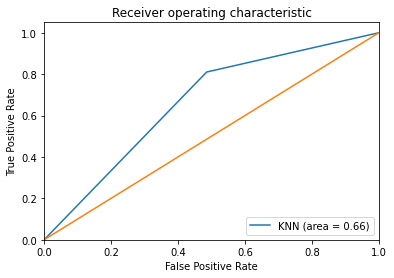

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:])
plt.figure()
plt.plot(fpr, tpr, label='KNN (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
startknn = time.perf_counter()

y_pred_valid = predictKNN(np.array(X_train),np.array(y_train),np.array(X_valid), 19)

f_score, recall, precision, accuracy = evaluate(y_valid, np.array(y_pred_valid).astype('int64'))
print('F1 score of test data {}'.format(f_score))
print('Recall of test data {}'.format(recall))
print('Precision of test data {}'.format(precision))
print('Accuracy of test data {}'.format(accuracy))


endknn = time.perf_counter()

print('Completed in', endknn - startknn)

knn_timer = endknn - startknn

[[261 250]
 [143 554]]
F1 score of test data 0.6746688741721855
Recall of test data 0.7948350071736011
Precision of test data 0.6890547263681592
Accuracy of test data 0.7381745502998002
Completed in 126.45513539999979


### We will be now using Neural Networks for training and testing

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Defining our sequential model
nn = Sequential()
nn.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(16, activation='sigmoid'))
nn.add(Dense(1))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [ ]:
nn.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
startnn = time.perf_counter()

EPOCHS = 10
BATCH_SIZE = 10
history = nn.fit(X_train, y_train_n, validation_data=(X_test, y_test_n), epochs=EPOCHS, batch_size=BATCH_SIZE)



endnn = time.perf_counter()

print('Execution Completed in:', endnn - startnn)

nn_timer = endnn - startnn

Epoch 1/10
967/967 [==============================] - 2s 1ms/step - loss: 0.7203 - accuracy: 0.5313 - val_loss: 0.6759 - val_accuracy: 0.5124
Epoch 2/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6683 - accuracy: 0.5757 - val_loss: 0.6707 - val_accuracy: 0.5141
Epoch 3/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6617 - accuracy: 0.5764 - val_loss: 0.6602 - val_accuracy: 0.6109
Epoch 4/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6590 - accuracy: 0.5857 - val_loss: 0.6559 - val_accuracy: 0.6026
Epoch 5/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6533 - accuracy: 0.5960 - val_loss: 0.6574 - val_accuracy: 0.5786
Epoch 6/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6503 - accuracy: 0.5947 - val_loss: 0.6537 - val_accuracy: 0.6101
Epoch 7/10
967/967 [==============================] - 1s 1ms/step - loss: 0.6457 - accuracy: 0.6020 - val_loss: 0.6463 - val_accuracy: 0.5762
Epoch 

In [ ]:
score = nn.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.620867133140564
Test accuracy: 0.6548013091087341


In [ ]:
score = nn.evaluate(X_valid, y_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6139121651649475
Test accuracy: 0.6564569473266602


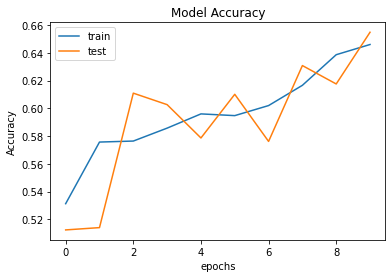

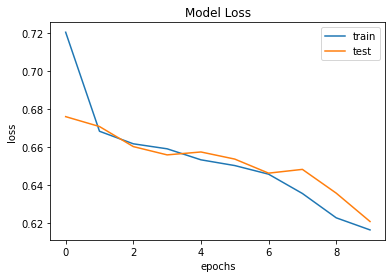

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### From the above graphs, we observe that the training accuracy, constantly kept on increasing in a linear fashion. But, the testing accuracy showed some fluctuation (sudden drops), but evetually reached a mark of 65 %

### Also, both the training and testing loss kept on constantly kept on decreasing throughout the training, which is feasible enough

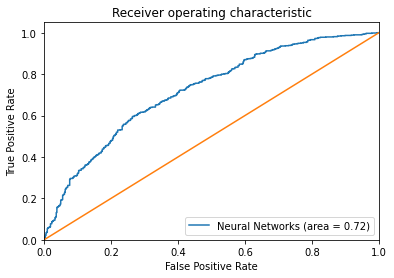

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, nn.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, nn.predict(X_test)[:])
plt.figure()
plt.plot(fpr, tpr, label='Neural Networks (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Support Vector Machine:

In [ ]:
class SVM():
    def __init__(self, max_iter=100, kernel_type='linear', C=1.0, e_p=0.001):
        self.kernels = {
            'linear' : self.kernel_linear,
            'quadratic' : self.kernel_quadratic,
            'gaussian' : self.kernel_gauss
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.e_p = e_p
    def fit(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alp = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        while True:
            count += 1
            alp_prev = np.copy(alp)
            for j in range(0, n):
                i = self.get_rnd_int(0, n-1, j) # Get random int i~=j
                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                if k_ij == 0:
                    continue
                alp_pr_j, alp_pr_i = alp[j], alp[i]
                (L, H) = self.compute_L_H(self.C, alp_pr_j, alp_pr_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alp, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alp values
                alp[j] = alp_pr_j + float(y_j * (E_i - E_j))/k_ij
                alp[j] = max(alp[j], L)
                alp[j] = min(alp[j], H)

                alp[i] = alp_pr_i + y_i*y_j * (alp_pr_j - alp[j])
#                 if(j % 100 == 0):
#                     print(j)
            # Check convergence
            diff = np.linalg.norm(alp - alp_prev)
            if diff < self.e_p:
                break
            #print(count)
            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alp, y, X)
        # Get support vectors
        alp_idx = np.where(alp > 0)[0]
        support_vectors = X[alp_idx, :]
        return support_vectors, count
    def predict(self, X):
        return self.h(X, self.w, self.b)
    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)
    def calc_w(self, alp, y, X):
        return np.dot(X.T, np.multiply(alp,y))
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k
    def compute_L_H(self, C, alp_pr_j, alp_pr_i, y_j, y_i):
        if(y_i != y_j):
            return (max(0, alp_pr_j - alp_pr_i), min(C, C - alp_pr_i + alp_pr_j))
        else:
            return (max(0, alp_pr_i + alp_pr_j - C), min(C, alp_pr_i + alp_pr_j))
    def get_rnd_int(self, a,b,z):
        i = z
        cnt=0
        while i == z and cnt<1000:
            i = rnd.randint(a,b)
            cnt=cnt+1
        return i
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)
    def kernel_gauss(self,x1, x2, sigma=1):
        return np.exp(- (np.linalg.norm(x1 - x2, 2)) * 2 / (2 * sigma * 2))
    def predict_proba(self, X):
        return np.dot(self.w.T, X.T) + self.b


In [ ]:
#SVM
X = df.drop(columns = ['Y'])
Y= df['Y']
X_train, X_rem, y_train, y_rem = train_test_split(X,Y, train_size=0.8)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)


In [ ]:
y_train_s=pd.DataFrame()
y_train_s=y_train.copy()
y_test_s=pd.DataFrame()
y_test_s=y_test.copy()
y_train_s.replace(0, -1, inplace=True) 
y_test_s.replace(0, -1, inplace=True) 

In [ ]:
model = SVM(max_iter=1000, kernel_type='linear', C=0.55, e_p=0.0001)
start_time = time.time()
model.fit(X_train.astype(float).to_numpy(),y_train_s.astype(float).to_numpy())
print("--- %s mins ---" % ((time.time() - start_time)/60.0))


--- 3.9356396476427715 mins ---


### Now predict the values using .predict() function on testing and validation data

In [ ]:
Y_predicted = [model.predict(x) for x in X_test.to_numpy()]

print(classification_report(y_test_s, Y_predicted))


              precision    recall  f1-score   support

          -1       0.52      0.61      0.56       492
           1       0.70      0.62      0.66       716

    accuracy                           0.61      1208
   macro avg       0.61      0.61      0.61      1208
weighted avg       0.63      0.61      0.62      1208



In [ ]:
confusion_matrix(y_test_s, Y_predicted)

array([[299, 193],
       [273, 443]], dtype=int64)

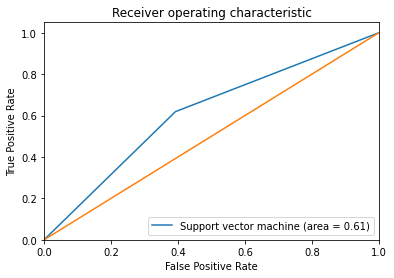

In [ ]:
svm_roc_auc = roc_auc_score(y_test_s, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test_s, model.predict(X_test)[:])
plt.figure()
plt.plot(fpr, tpr, label='Support vector machine (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
y_valid_s=pd.DataFrame()
y_valid_s=y_valid.copy()

In [ ]:
Y_predicted_v = [model.predict(x) for x in X_valid.to_numpy()]
for i in range(len(Y_predicted_v)):
    if Y_predicted_v[i] == -1:
        Y_predicted_v[i] = 0
print(classification_report(y_valid_s, Y_predicted_v))

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       516
           1       0.69      0.65      0.67       692

    accuracy                           0.63      1208
   macro avg       0.62      0.62      0.62      1208
weighted avg       0.63      0.63      0.63      1208



In [ ]:
confusion_matrix(y_valid_s, Y_predicted_v)

array([[310, 206],
       [244, 448]], dtype=int64)

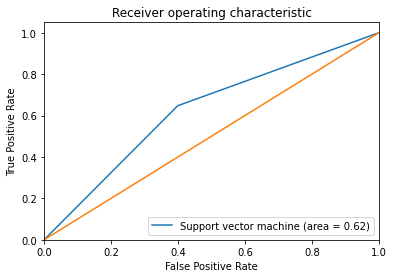

In [ ]:
svm_roc_auc = roc_auc_score(y_valid_s, model.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid_s, model.predict(X_valid)[:])
plt.figure()
plt.plot(fpr, tpr, label='Support vector machine (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Performance Evaluation:

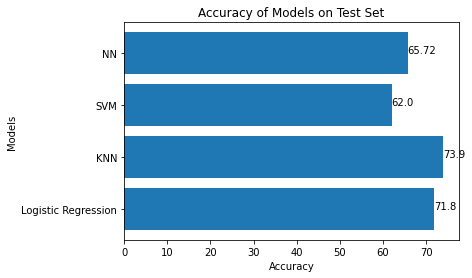

<Figure size 72000x14400 with 0 Axes>

In [ ]:
x = ['Logistic Regression','KNN','SVM','NN']
y = [71.8, 73.9, 62.0, 65.72]
plt.barh(x, y)

for index, value in enumerate(y):
    plt.text(value, index,
            str(value))
plt.title("Accuracy of Models on Test Set")
plt.xlabel("Accuracy")
plt.ylabel("Models")
plt.figure(figsize = (1000, 200))
plt.show()

References; 
1. https://medium.com/geekculture/a-primer-on-machine-learning-and-data-analysis-5f19fd734c5a
2. https://medium.com/swlh/exploratory-data-analysis-eda-from-scratch-in-python-8c12c2673aa7
3. https://scikit-learn.org/stable/modules/svm.html
4. https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47
5. https://towardsdatascience.com/deep-learning-with-python-neural-networks-complete-tutorial-6b53c0b06af0